<a href="https://colab.research.google.com/github/skywalker0803r/Wastewater-Biological-Treatment/blob/main/%E5%9F%B9%E9%A4%8A%E6%99%82%E9%96%93%E5%B0%8D%E5%BE%AE%E7%94%9F%E7%89%A9%E7%9B%B8%E5%B0%8D%E6%95%B8%E9%87%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

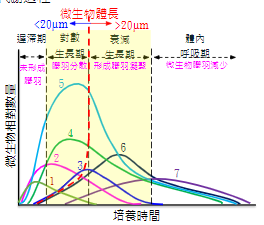

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
尾絲蟲


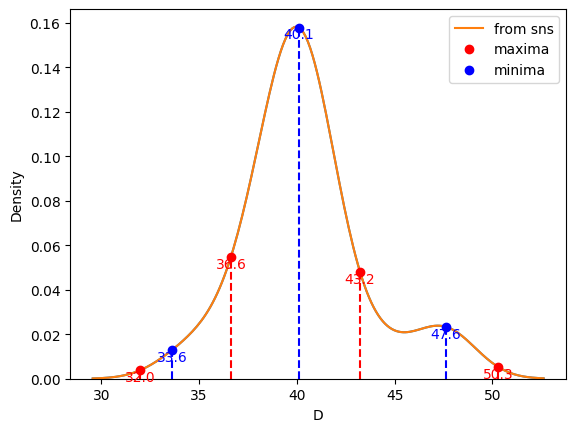

螺旋菌


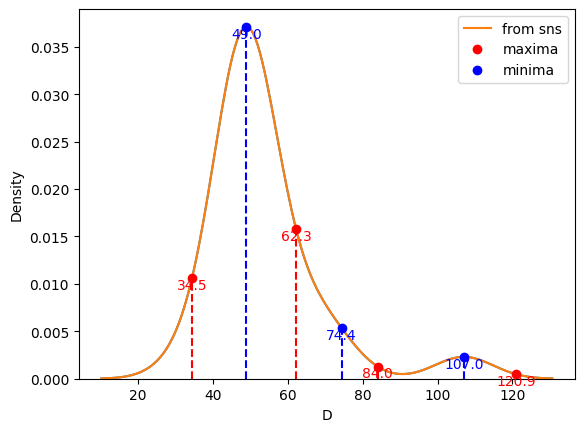

斜管蟲


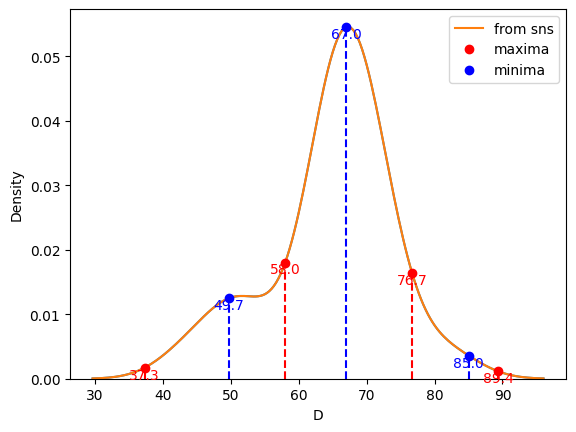

變形蟲2


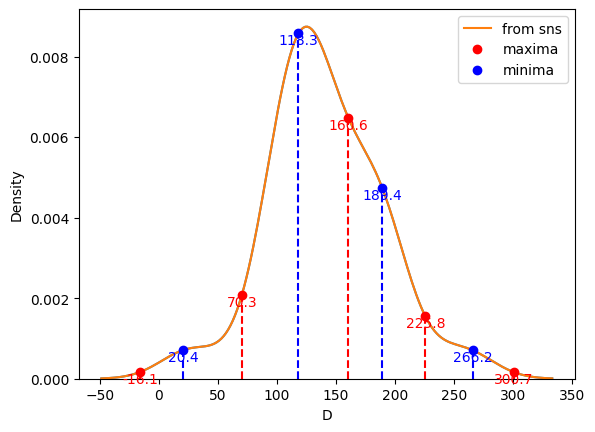

變形蟲


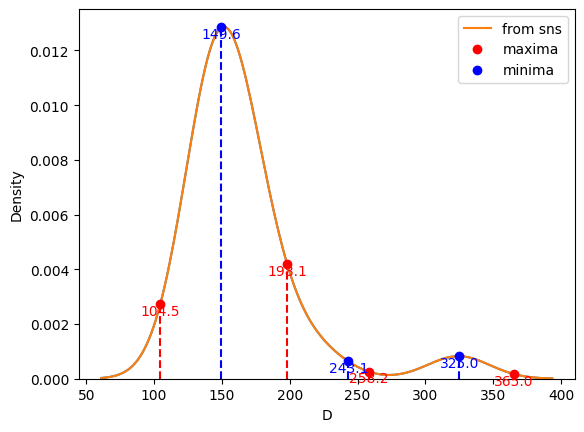

輪蟲幼蟲


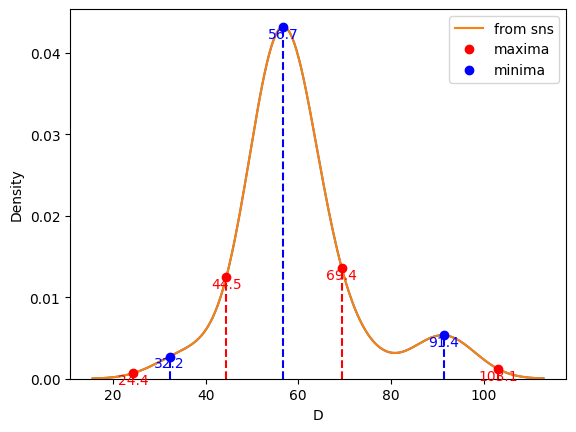

單鐮蟲


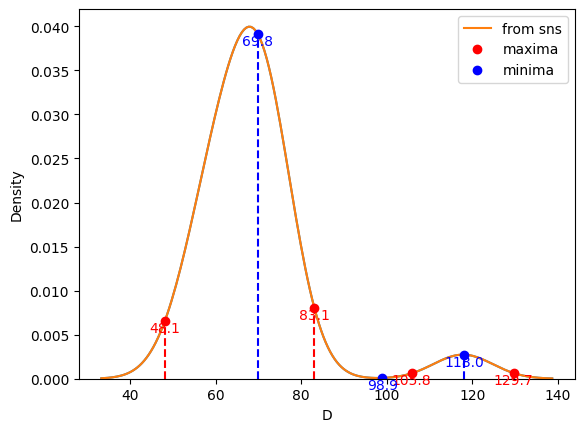

腔輪蟲


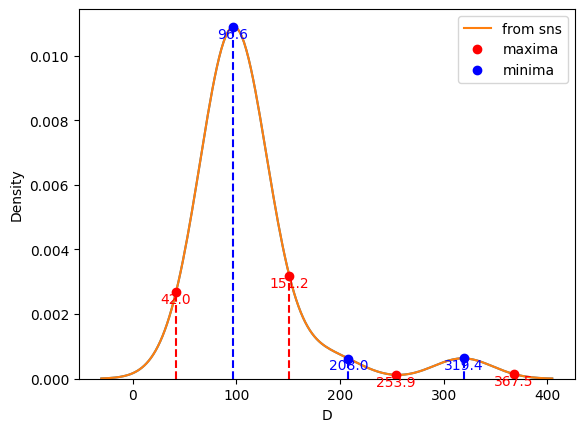

膜袋蟲


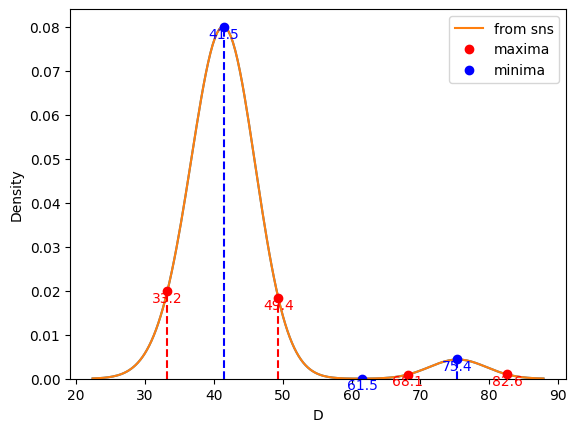

單領鞭毛蟲


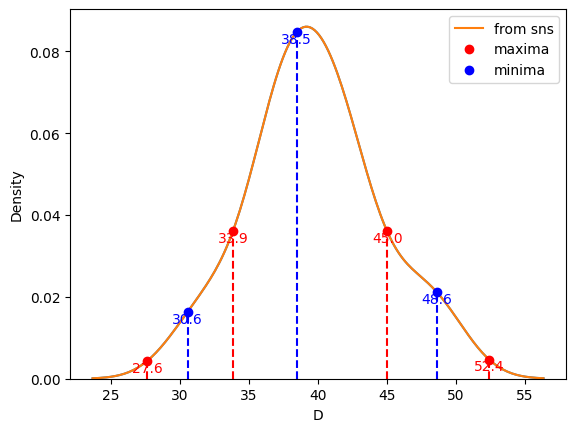

輪蟲類


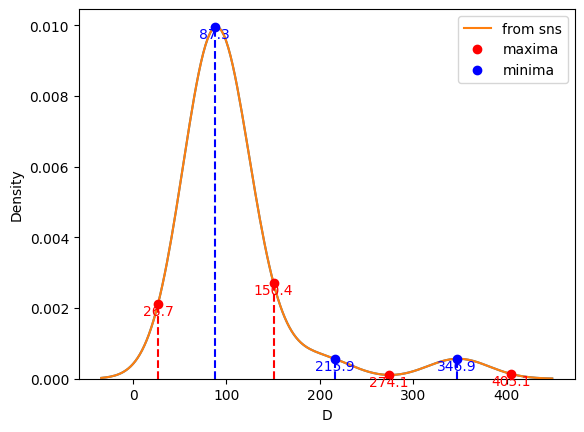

漫遊蟲


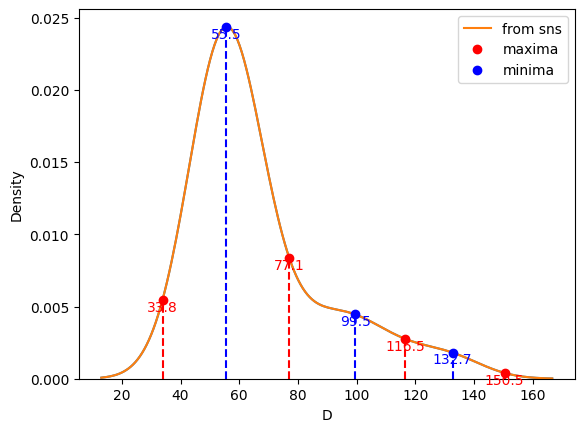

滴蟲


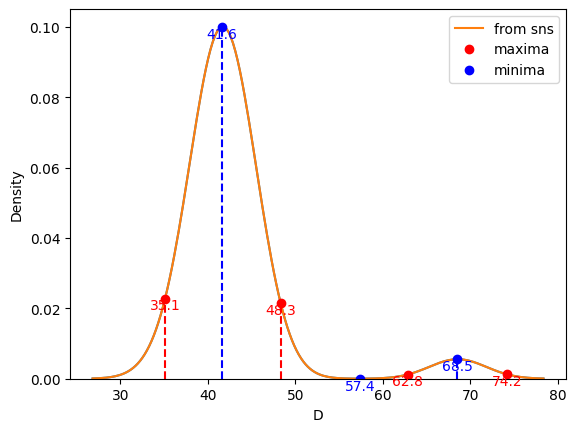

表殼蟲


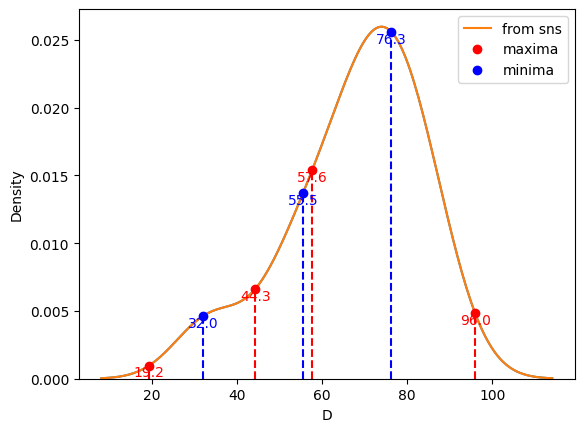

太陽蟲


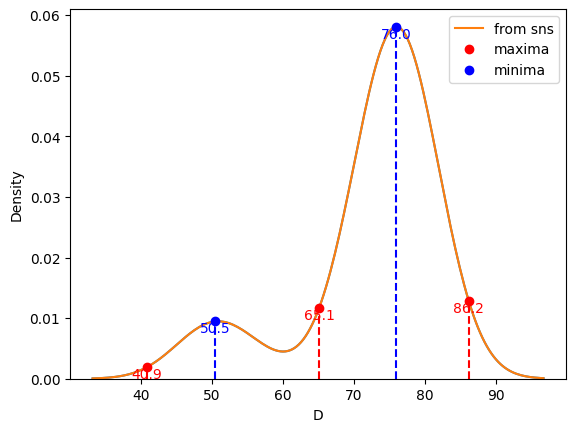

In [74]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

df1 = pd.read_csv('/content/drive/MyDrive/廢水案子/ALLdataset.csv',index_col = 0)
df1

def load_df2():
  path = '/content/drive/MyDrive/專案工作承攬契約書_廢水生物處理/2.20210101-20220430資料(整理).xlsx'
  df = pd.read_excel(path,index_col=0)
  var1 = df.iloc[0,:].values
  var2 = df.iloc[1,:].values
  # 專有名詞對照表
  專有名詞對照表 = pd.concat([pd.Series(var1), pd.Series(var2)], axis=1).T
  專有名詞對照表.index = ['詳細名稱', '英文名稱']
  # 指定第一行為欄位名稱
  df.columns = df.iloc[1]  
  # 去掉前兩行因為是欄位名稱
  df = df.iloc[2:]  
  # cell都轉換成numeric
  for i in df.columns:
    df[i] = pd.to_numeric(df[i],errors='coerce')
  return df,專有名詞對照表
df2,專有名詞對照表 = load_df2()
df2.index = pd.to_datetime(df2.index).strftime('%Y%m%d').astype(df1.index)
df2

df = df1.join(df2)
df

need_cols = ['cName','D','PHL_T751-COD_ppm','PHL_A771-COD_ppm']
df = df.loc[:,need_cols]
df = df.dropna(axis=0)
df

cName_list = list(set(df['cName'].unique())-set(['絲狀菌']))
cName_list

def transform_data(df,cName):
  # select_data
  d = df.loc[df['cName']==cName]
  
  # 10day resample
  d.index = pd.to_datetime(d.index, format='%Y%m%d')
  d = d.resample('10D').mean()
  
  # add cName
  d['cName'] = cName
  
  # cacluate COD diffrence
  d['COD差異量'] = d['PHL_T751-COD_ppm']-d['PHL_A771-COD_ppm']
  
  # cluster by D
  d_quantiles = d['D'].quantile([i / 10.0 for i in range(9)])
  def label_function(value):
    for i, quantile in enumerate(d_quantiles):
      if value <= quantile:
        return i
    return len(d_quantiles)  
  d['label'] = d['D'].apply(label_function)
  return d

temp = pd.DataFrame()
for cName in cName_list:
  temp = temp.append(transform_data(df,cName))
df = temp
df     

import seaborn as sns
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

for cName in df.cName.unique():
    arr = df.loc[df.cName==cName,'D']
    x, y = sns.kdeplot(arr).lines[0].get_data()
    plt.plot(x, y, label='from sns')
    curvature = np.gradient(np.gradient(y, x), x)
    maxima_indices = argrelextrema(curvature, np.greater)[0]
    minima_indices = argrelextrema(curvature, np.less)[0]
    plt.plot(x[maxima_indices], y[maxima_indices], 'ro', label='maxima')
    plt.plot(x[minima_indices], y[minima_indices], 'bo', label='minima')

    # 绘制垂直线并标示数值
    for idx in maxima_indices:
        plt.vlines(x[idx], 0, y[idx], colors='r', linestyles='dashed')
        plt.text(x[idx], y[idx], f'{x[idx]:.1f}', ha='center', va='top', color='r')
    for idx in minima_indices:
        plt.vlines(x[idx], 0, y[idx], colors='b', linestyles='dashed')
        plt.text(x[idx], y[idx], f'{x[idx]:.1f}', ha='center', va='top', color='b')
    print(cName)
    plt.legend()
    plt.show()